In [3]:
#!pip install seaborn
#!pip install torch torchtext
#!pip install pytorch-forecasting
#!pip install transformers[torch]
#!pip install evaluate
#!pip install torchtext
!pip list | grep -E 'seaboarn|torch|torchtext|transformers|evaluate'

evaluate                  0.4.1
pytorch-forecasting       1.0.0
pytorch-lightning         2.1.2
pytorch_optimizer         2.12.0
torch                     2.1.1
torchdata                 0.7.1
torchmetrics              1.2.0
torchtext                 0.16.1
transformers              4.35.2


In [57]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchtext
from datasets import Dataset
from typing import Optional

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [8]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
zip_path = 'jena_climate_2009_2016.csv.zip'
to_path = './data'

In [9]:
torchtext.utils.download_from_url(url, zip_path)
torchtext.utils.extract_archive(zip_path, to_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 10.5MB/s]


['./data/jena_climate_2009_2016.csv']

In [10]:
csv_path, _ = os.path.splitext(zip_path)

In [16]:
df = pd.read_csv(to_path+'/'+csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

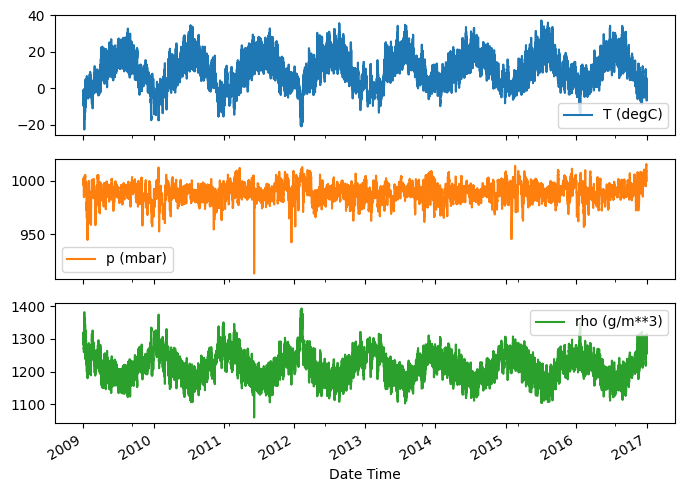

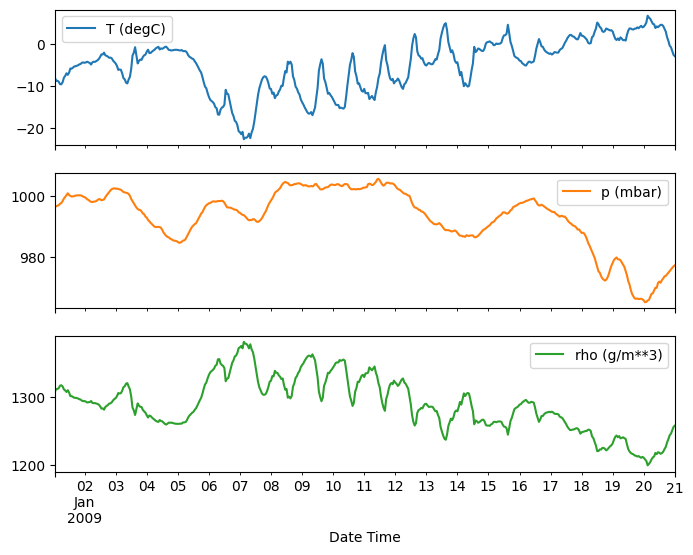

In [17]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [19]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

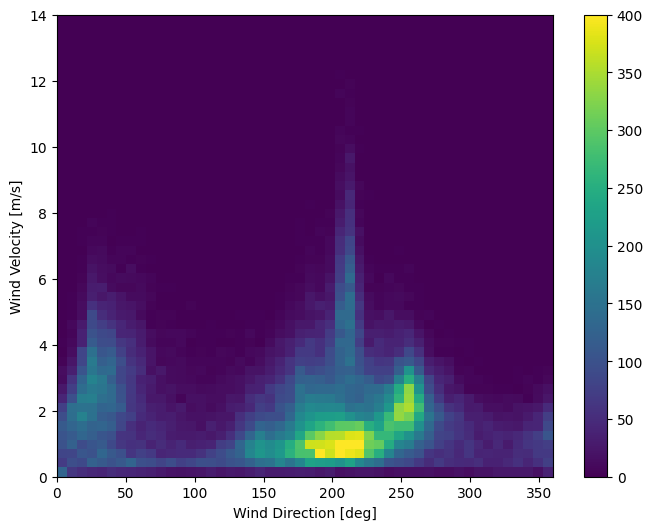

In [20]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [21]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [22]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [23]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [24]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [25]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

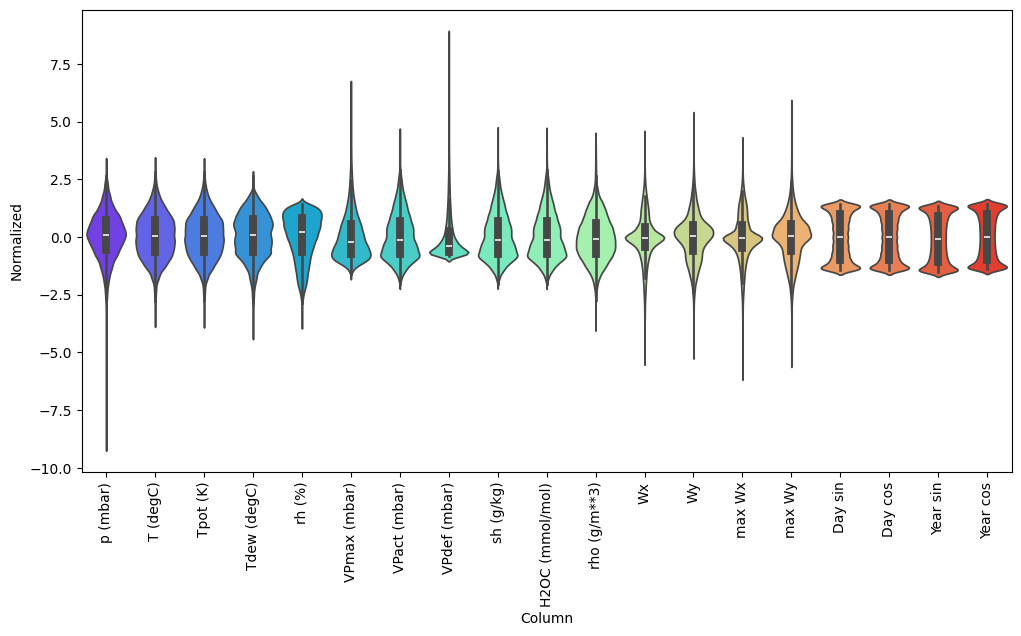

In [26]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std, palette="rainbow", hue='Column')
ax.set_xticks(ax.get_xticks()) # to avoid warning for set_xticklabels
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [27]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, data, seq_len, w):
        self.data = data
        self.seq_len = seq_len
        self.w = w # window generator

    def __len__(self):
        return len(self.data) - (self.seq_len-1)

    def __getitem__(self, index):
        features = self.data[index:index+self.seq_len];
        inputs, labels = self.w.split_dataset(features)
        return { 'inputs': inputs, 'labels': labels }

In [61]:
from sklearn.preprocessing import StandardScaler

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 df = df,
                 label_columns=None):
        
        self.column_indices = {name: i for i, name in enumerate(df.columns)}

        # Store the raw data.
        n = len(df)
        self.train_df = df[0:int(n*0.7)]
        self.val_df = df[int(n*0.7):int(n*0.9)]
        self.test_df = df[int(n*0.9):]

        # standardize by training set
        self.scaler = StandardScaler()
        self.scaler.fit(train_df.values)

        def scale_df(df, scaler):
            data = scaler.transform(df.values)
            return pd.DataFrame(data, index=df.index, columns=df.columns)

        self.train_df = scale_df(train_df, self.scaler)
        self.val_df = scale_df(val_df, self.scaler)
        self.test_df = scale_df(test_df, self.scaler)

        self.num_features = df.shape[1]

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                             enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        self.train = self.make_dataset(self.train_df, shuffle=True)
        self.val = self.make_dataset(self.val_df)
        self.test = self.make_dataset(self.test_df)

    def __repr__(self):
        return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = torch.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
           axis=-1)
    
      return inputs, labels

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index].cpu(),
                     label='Inputs', marker='.', zorder=-10)
        
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
        
            if label_col_index is None:
                continue
        
            plt.scatter(self.label_indices, labels[n, :, label_col_index].cpu(),
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model.model(inputs)['pred'].cpu().detach()
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
        
            if n == 0:
                plt.legend()
      
        plt.xlabel('Time [h]')
    
    def split_dataset(self, features):
        inputs = features[self.input_slice, :]
        labels = features[self.labels_slice, :]
        if self.label_columns is not None:
            labels = np.stack(
                [labels[:, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
      
        return inputs, labels
        

    def make_dataset(self, data, shuffle=False):
        def data_gen(ds):
            for i in range(len(ds)):
                yield(ds[i])
        data = np.array(data, dtype=np.float32)
        tsds = TimeseriesDataset(
            data=data,
            seq_len=self.total_window_size,
            w=self)
        ds = Dataset.from_generator(data_gen, gen_kwargs={'ds': tsds})
        ds = ds.with_format("torch")
        if shuffle:
            ds = ds.shuffle(seed=42)
      
        return ds

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            #result = next(iter(self.train))
            result = self.train[0:32]
            #result = torch.unsqueeze(result['inputs'],0), torch.unsqueeze(result['labels'],0)
            result = result['inputs'].to('cuda'), result['labels'].to('cuda')
            # And cache it for next time
            self._example = result
        return result
    


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

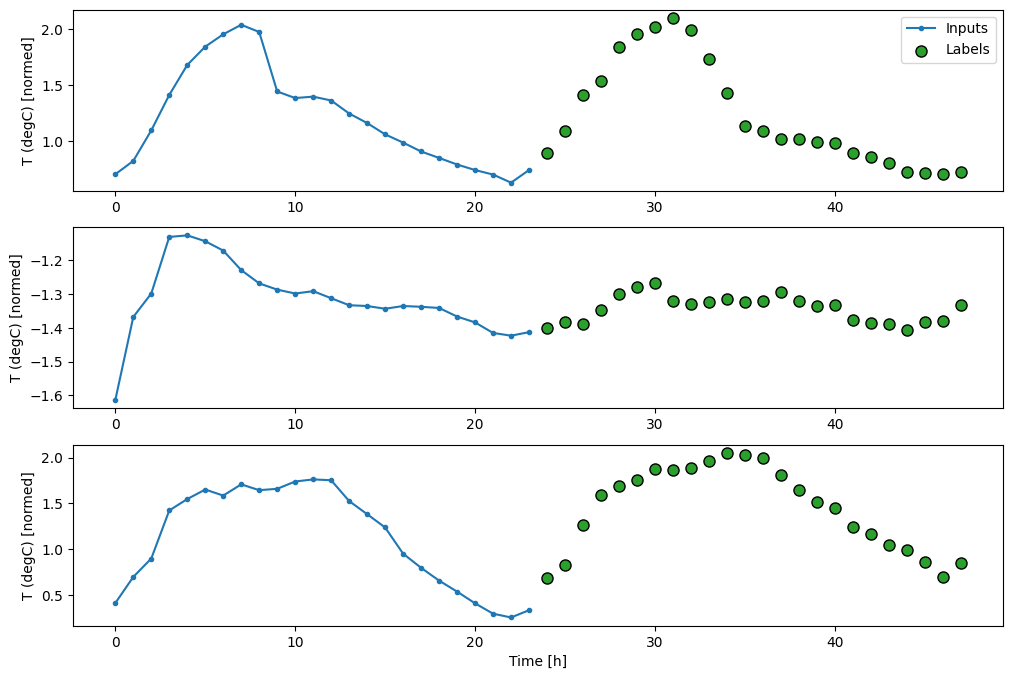

In [62]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [63]:
from transformers import TrainingArguments, Trainer
import evaluate
from torchmetrics.regression import MeanAbsoluteError
mean_absolute_error = MeanAbsoluteError()
from transformers import EarlyStoppingCallback

def compute_metrics(evalpred):
    
    preds, labels = evalpred
    preds = torch.Tensor(preds)
    labels = torch.Tensor(labels)
    result = mean_absolute_error(preds, labels)
            
    return {
        "mae" : result
    }

In [64]:
training_args = TrainingArguments(
                    output_dir="test_trainer",
                    num_train_epochs=20,
                    evaluation_strategy = "steps",
                    per_device_train_batch_size = 32,
                    per_device_eval_batch_size = 256,
                    load_best_model_at_end = True,
                    metric_for_best_model = 'eval_mae',
                    greater_is_better = False,
                    learning_rate=0.001,
                    disable_tqdm=False,
                )

In [65]:
class MultiStepLastBaseline(torch.nn.Module):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
    #def forward(self, inputs, targets, return_loss=True):
        targets = labels
        result = torch.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
        if targets is None:
            return {
                'pred': result
            }
        if self.label_index is None:
            return { 
                'loss': torch.mean(self.mse(result, targets),1),
                'pred': result
            }
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }

In [66]:
last_baseline_model = MultiStepLastBaseline()

last_baseline = Trainer(
    model=last_baseline_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics
    #data_collator=data_collator,
)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)['eval_mae']
multi_performance['Last'] = last_baseline.evaluate(multi_window.test)['eval_mae']

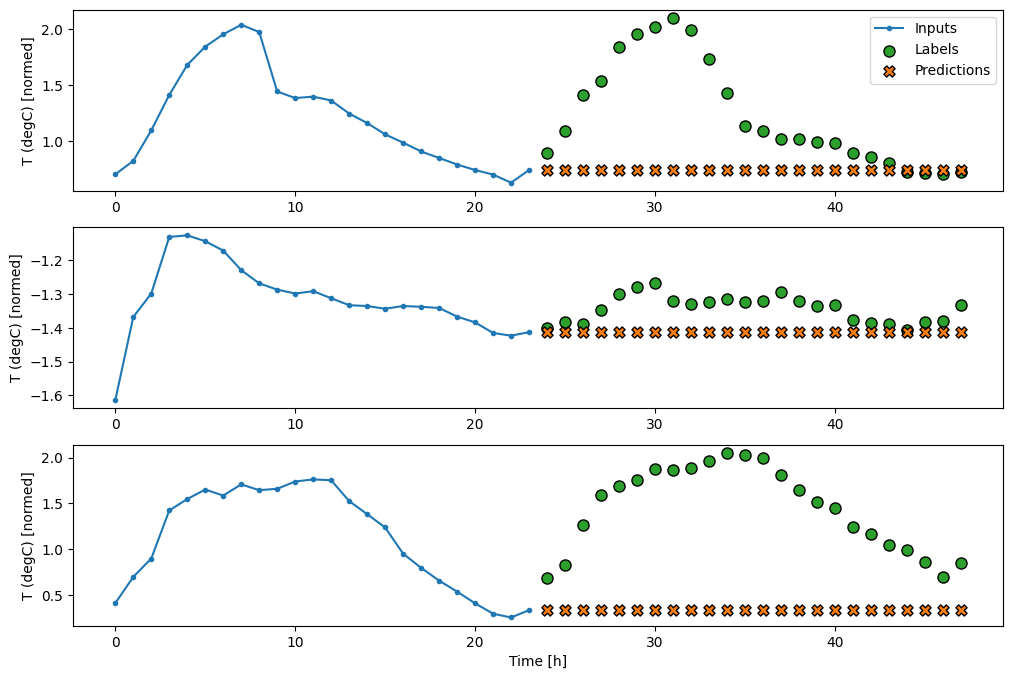

In [67]:
multi_window.plot(last_baseline)

In [68]:
import transformers
def reset_progress(trainer):
    for callback in trainer.callback_handler.callbacks:
        if isinstance(callback, transformers.utils.notebook.NotebookProgressCallback):
            callback.training_tracker = None
            callback.prediction_bar = None
            callback._force_next_update = False

In [69]:
class RepeatBaseline(torch.nn.Module):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
    #def forward(self, inputs, targets, return_loss=True):
        targets = labels
        n_inputs = int(inputs.shape[1])
        n_targets = OUT_STEPS
        n_tile = n_inputs//n_targets
        n_remain = n_inputs%n_targets
        if n_inputs > 0:
            result = torch.tile(inputs[:, :, :], [1, n_tile, 1])
        else:
            result = inputs
        if n_remain > 0:
            result = torch.cat([result, inputs[:, 0:n_remain, :]], 0)
        
        if targets is None:
            return {
                'pred': result
            }
        if self.label_index is None:
            return { 
                'loss': torch.mean(self.mse(result, targets),1),
                'pred': result
            }
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
repeat_baseline_model = RepeatBaseline()
repeat_baseline = Trainer(
    model=repeat_baseline_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics
    #data_collator=data_collator,
)
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)['eval_mae']
reset_progress(repeat_baseline)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)['eval_mae']

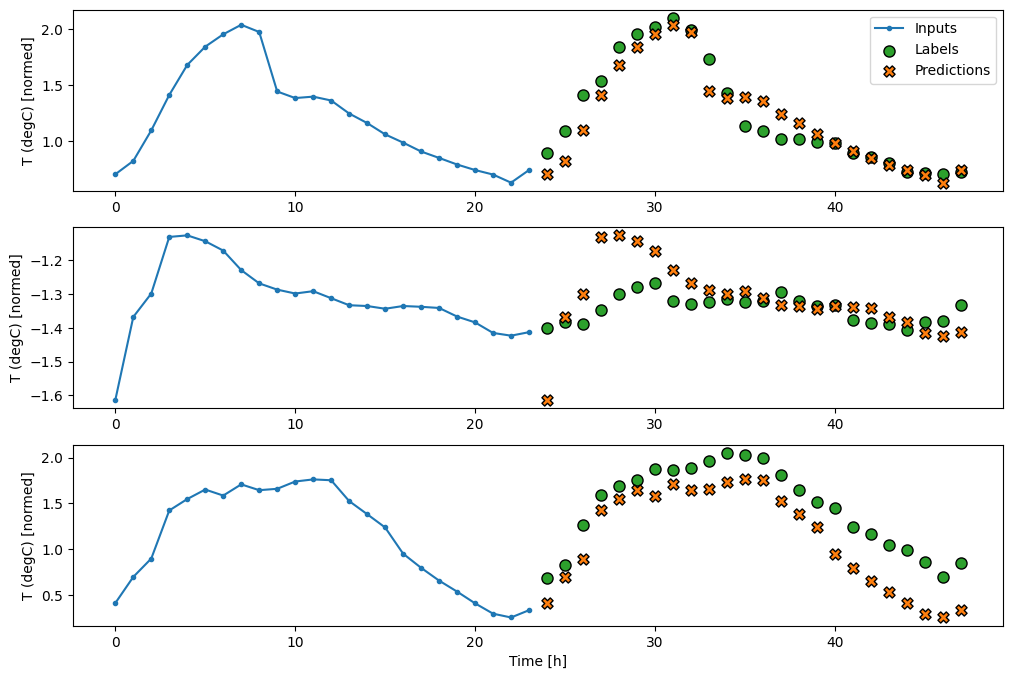

In [70]:
multi_window.plot(repeat_baseline)

In [71]:
class MultiDense(torch.nn.Module):
    def __init__(self, label_index=None, channels=19):
        super().__init__()
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        self.linear1 = torch.nn.Linear(channels, 512)
        self.linear2 = torch.nn.Linear(512, OUT_STEPS*self.out_channels)
        self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels

        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        x = inputs[:, -1, :]
        
        # Shape => [batch, 1, dense_units]
        x = self.linear1(x)
        x = self.relu(x)
        
        # Shape => [batch, out_steps*features]
        x = self.linear2(x)
        
        # Shape => [batch, out_steps, features]
        result = x.reshape((-1, OUT_STEPS, self.out_channels))
        
        # https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
            
multi_dense_model = MultiDense(channels=19)

multi_dense = Trainer(
    model=multi_dense_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [72]:
%%time
multi_dense.train_dataset = multi_window.train
multi_dense.eval_dataset = multi_window.val

history = multi_dense.train()
print()

Step,Training Loss,Validation Loss,Mae
500,0.246900,0.225935,0.287253
1000,0.220800,0.223236,0.284801
1500,0.217400,0.220788,0.281750
2000,0.214500,0.220119,0.281149
2500,0.213200,0.217604,0.278875
3000,0.211000,0.219238,0.279997
3500,0.209700,0.216726,0.277886
4000,0.209100,0.216805,0.277891
4500,0.208100,0.217932,0.278199



CPU times: user 17min 6s, sys: 6.33 s, total: 17min 12s
Wall time: 8min 45s


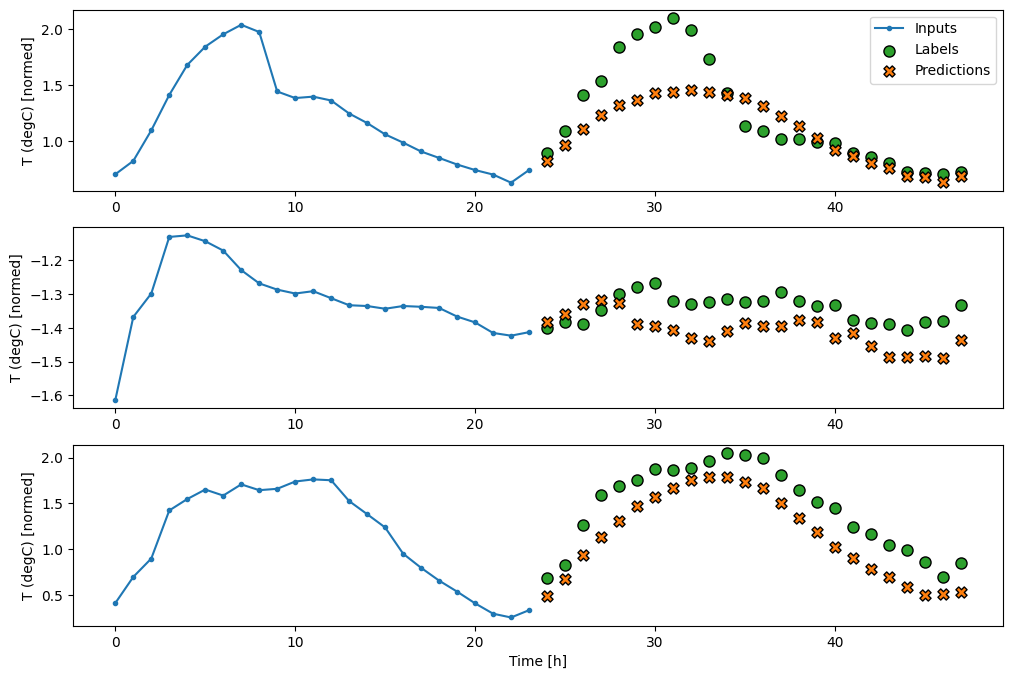

In [73]:
multi_val_performance['Dense'] = multi_dense.evaluate(multi_window.val)['eval_mae']
reset_progress(multi_dense)
multi_performance['Dense'] = multi_dense.evaluate(multi_window.test)['eval_mae']
multi_window.plot(multi_dense)

**TSMixer Pytorch**  
https://github.com/smrfeld/tsmixer-pytorch  
https://github.com/marcopeix/time-series-analysis/blob/master/TSMixer.ipynb  

In [92]:
import torch.nn as nn

class TSBatchNorm2d(nn.Module):

    def __init__(self):
        super(TSBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)

        # Reshape input_data to (batch_size, 1, timepoints, features)
        x = x.unsqueeze(1)

        # Forward pass
        output = self.bn(x)

        # Reshape the output back to (batch_size, timepoints, features)
        output = output.squeeze(1)
        return output

class TSTimeMixingResBlock(nn.Module):

    def __init__(self, width_time: int, dropout: float):
        super(TSTimeMixingResBlock, self).__init__()
        self.norm = TSBatchNorm2d()

        self.lin = nn.Linear(in_features=width_time, out_features=width_time)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.norm(x)
        
        # Now rotate such that shape is (batch_size, features, time)
        y = torch.transpose(y, 1, 2)
        
        # Apply MLP to time dimension
        y = self.lin(y)
        y = self.act(y)

        # Rotate back such that shape is (batch_size, time, features)
        y = torch.transpose(y, 1, 2)

        # Dropout
        y = self.dropout(y)
                
        # Add residual connection
        return x + y


class TSFeatMixingResBlock(nn.Module):

    def __init__(self, width_feats: int, width_feats_hidden: int, dropout: float):
        super(TSFeatMixingResBlock, self).__init__()
        self.norm = TSBatchNorm2d()

        self.lin_1 = nn.Linear(in_features=width_feats, out_features=width_feats_hidden)
        self.lin_2 = nn.Linear(in_features=width_feats_hidden, out_features=width_feats)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.act = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.norm(x)
        
        # Apply MLP to feat dimension
        y = self.lin_1(y)
        y = self.act(y)
        y = self.dropout_1(y)
        y = self.lin_2(y)
        y = self.dropout_2(y)
                
        # Add residual connection
        return x + y


class TSMixingLayer(nn.Module):

    def __init__(self, input_length: int, no_feats: int, feat_mixing_hidden_channels: int, dropout: float):
        super(TSMixingLayer, self).__init__()
        self.time_mixing = TSTimeMixingResBlock(width_time=input_length, dropout=dropout)
        self.feat_mixing = TSFeatMixingResBlock(width_feats=no_feats, width_feats_hidden=feat_mixing_hidden_channels, dropout=dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.time_mixing(x)
        y = self.feat_mixing(y)
        return y


class TSTemporalProjection(nn.Module):

    def __init__(self, input_length: int, forecast_length: int):
        super(TSTemporalProjection, self).__init__()
        self.lin = nn.Linear(in_features=input_length, out_features=forecast_length)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        # Now rotate such that shape is (batch_size, features, time=input_length)
        y = torch.transpose(x, 1, 2)

        # Apply linear projection -> shape is (batch_size, features, time=forecast_length)
        y = self.lin(y)

        # Rotate back such that shape is (batch_size, time=forecast_length, features)
        y = torch.transpose(y, 1, 2)
        return y


class TSMixerModelExclRIN(nn.Module):

    def __init__(self, input_length: int, forecast_length: int, no_feats: int, feat_mixing_hidden_channels: int, no_mixer_layers: int, dropout: float):
        super(TSMixerModelExclRIN, self).__init__()
        self.temp_proj = TSTemporalProjection(input_length=input_length, forecast_length=forecast_length)
        mixer_layers = []
        for _ in range(no_mixer_layers):
            mixer_layers.append(TSMixingLayer(input_length=input_length, no_feats=no_feats, feat_mixing_hidden_channels=feat_mixing_hidden_channels, dropout=dropout))
        self.mixer_layers = nn.ModuleList(mixer_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        for mixer_layer in self.mixer_layers:
            x = mixer_layer(x)

        # Apply temporal projection -> shape is (batch_size, time=forecast_length, features)
        x = self.temp_proj(x)

        return x


class TSMixerModel(nn.Module):
    """Include Reversible instance normalization https://openreview.net/pdf?id=cGDAkQo1C0p
    """    

    def __init__(self, 
                 input_length: int, 
                 forecast_length: int, 
                 no_feats: int, 
                 feat_mixing_hidden_channels: int, 
                 no_mixer_layers: int,  
                 dropout: float, 
                 eps: float = 1e-8):
        super(TSMixerModel, self).__init__()
        self.eps = eps

        # Scale and shift params to learn
        self.scale = nn.Parameter(torch.ones(no_feats))
        self.shift = nn.Parameter(torch.zeros(no_feats))

        # ts mixer layers
        self.ts = TSMixerModelExclRIN(
            input_length=input_length, 
            forecast_length=forecast_length, 
            no_feats=no_feats, 
            feat_mixing_hidden_channels=feat_mixing_hidden_channels,
            no_mixer_layers=no_mixer_layers,
            dropout=dropout
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)

        # Compute mean, var across time dimension
        # mean: (batch_size, 1, features)
        # var: (batch_size, 1, features)
        mean = torch.mean(x, dim=1, keepdim=True)
        var = torch.var(x, dim=1, keepdim=True)

        # Normalize across time dimension
        # x: (batch_size, time, features)
        x = (x - mean) / torch.sqrt(var + self.eps)

        # Apply scale and shift in each feature dimension separately
        # x: (batch_size, time, features)
        # scale: (features)
        # shift: (features)
        x = x * self.scale + self.shift

        # Apply ts mixer layers
        x = self.ts(x)

        # Apply inverse scale and shift in each feature dimension separately
        # x: (batch_size, time, features)
        # scale: (features)
        # shift: (features)
        x = (x - self.shift) / self.scale

        # Unnormalize across time dimension
        # x: (batch_size, time, features)
        # mean: (batch_size, 1, features)
        # var: (batch_size, 1, features)
        x = x * torch.sqrt(var + self.eps) + mean

        return x

In [105]:
class TSMixer(torch.nn.Module):
    def __init__(self,
                 label_index=None, input_length=24, forecast_length=OUT_STEPS,
                 no_feats=19,
                 feat_mixing_hidden_channels=64,
                 no_mixer_layers=8,
                 dropout=0.7):
        super().__init__()

        self.tsmixermodel = TSMixerModel(input_length=input_length,
                                          forecast_length=forecast_length,
                                          no_feats=no_feats, 
                                          feat_mixing_hidden_channels=feat_mixing_hidden_channels,
                                          no_mixer_layers=no_mixer_layers,
                                          dropout=dropout)

        channels = no_feats
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        #self.linear1 = torch.nn.Linear(channels, 512)
        #self.linear2 = torch.nn.Linear(512, OUT_STEPS*self.out_channels)
        #self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ):
        targets = labels

        x = self.tsmixermodel(inputs)

        result = x
        
        # https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
        if targets is not None:
            loss = torch.mean(self.mse(result, targets), 1)
            return {
                'loss': loss, 
                'pred': result
            }
        else:
            return {
                'pred': result
            }
            
tsmixer_model = TSMixer(label_index=None,
                        input_length=24,
                        forecast_length=OUT_STEPS,
                        no_feats=19,
                        feat_mixing_hidden_channels=64,
                        no_mixer_layers=4,
                        dropout=0.3)

tsmixer_training_args = TrainingArguments(
                    output_dir="test_trainer",
                    num_train_epochs=20,
                    evaluation_strategy = "steps",
                    per_device_train_batch_size = 64,
                    per_device_eval_batch_size = 256,
                    load_best_model_at_end = True,
                    metric_for_best_model = 'eval_mae',
                    greater_is_better = False,
                    learning_rate=0.0001,
                    disable_tqdm=False,
                )

tsmixer = Trainer(
    model=tsmixer_model,
    args=training_args,
    #train_dataset=single_step_window.val
    #eval_dataset=single_step_window.val,
    #eval_dataset=small_eval_dataset,
    #compute_metrics=mean_absolute_error,
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

In [ ]:
%%time
tsmixer.train_dataset = multi_window.train
tsmixer.eval_dataset = multi_window.val

history = tsmixer.train()
print()

Step,Training Loss,Validation Loss,Mae
500,0.316400,0.272853,0.319107
1000,0.269900,0.265095,0.312712
1500,0.262000,0.258112,0.306355
2000,0.256500,0.254108,0.304313
2500,0.253900,0.251816,0.301345
3000,0.251700,0.250287,0.299153
3500,0.250000,0.249930,0.300212
4000,0.249800,0.248835,0.298371
4500,0.248000,0.248705,0.298183
5000,0.248100,0.247740,0.298059


In [99]:
%%time
tsmixer.train_dataset = multi_window.train
tsmixer.eval_dataset = multi_window.val

history = tsmixer.train()
print()

Step,Training Loss,Validation Loss,Mae
500,0.401700,0.286129,0.333781
1000,0.285600,0.274596,0.319573
1500,0.275800,0.268963,0.314028
2000,0.270200,0.265272,0.311789
2500,0.267400,0.263178,0.309161
3000,0.264900,0.261464,0.307197
3500,0.263300,0.260561,0.307449
4000,0.262900,0.259860,0.305847
4500,0.261200,0.258908,0.305395
5000,0.261300,0.258234,0.305448



CPU times: user 30min 7s, sys: 45.2 s, total: 30min 52s
Wall time: 15min 39s


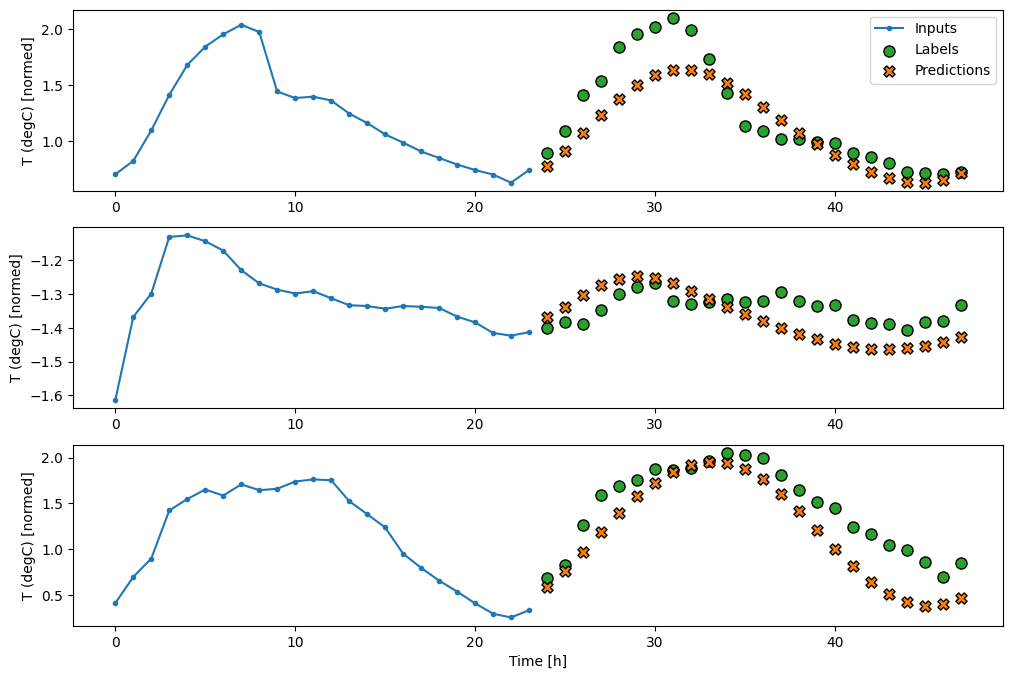

In [107]:
multi_val_performance['TSMixer'] = tsmixer.evaluate(multi_window.val)['eval_mae']
reset_progress(tsmixer)
multi_performance['TSMixer'] = tsmixer.evaluate(multi_window.test)['eval_mae']
multi_window.plot(tsmixer)

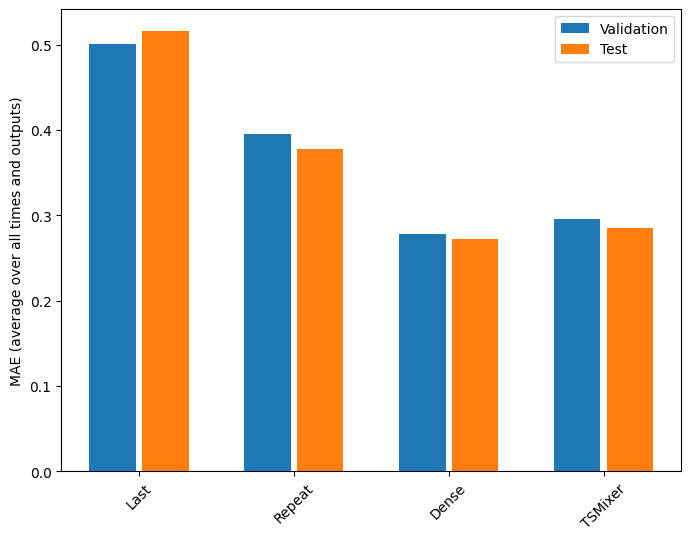

In [108]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v for v in multi_val_performance.values()]
test_mae = [v for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [102]:
multi_val_performance, multi_performance

({'Last': 0.5007242560386658,
  'Repeat': 0.39587876200675964,
  'Dense': 0.277885764837265,
  'TSMixer': 0.30539464950561523},
 {'Last': 0.5156692862510681,
  'Repeat': 0.3773890733718872,
  'Dense': 0.27275949716567993,
  'TSMixer': 0.2946922183036804})

In [109]:
multi_val_performance, multi_performance

({'Last': 0.5007242560386658,
  'Repeat': 0.39587876200675964,
  'Dense': 0.277885764837265,
  'TSMixer': 0.2962418794631958},
 {'Last': 0.5156692862510681,
  'Repeat': 0.3773890733718872,
  'Dense': 0.27275949716567993,
  'TSMixer': 0.2852451503276825})

In [110]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,-0.855154,-0.160038,-1.336792,-0.250174,-0.953717,0.300706,0.006900,0.999976
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,-0.716196,-0.726267,-1.348134,-1.367090,-0.843391,0.537300,0.007617,0.999971
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,-0.661501,0.257908,-1.453438,0.566672,-0.675590,0.737277,0.008334,0.999965
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,-0.280621,-0.209169,-0.545207,-0.406385,-0.461749,0.887011,0.009050,0.999959
